In [1]:
import os, math
import csv
import tempfile
import shutil
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt


# GLOBAL CONSTANTS

window_size = 25                 # for G1, G2 computation in milliseconds
initial_tolerance_percent = 10
tolerance_factor = 1.5           # Peak detection tolerance param setting
width = 350                      # Peak detection width param setting
window_length = 101              # Window length of the filter (odd number)
polynomial_order = 5             # Polynomial order used to fit the samples
number_of_grids = 2



In [2]:
# FUNCTION DEFINITIONS

def nearest_odd(number):
    if number % 2 == 0:
        # If the number is even, return the next odd number
        return number - 1
    else:
        # If the number is odd, return the number itself
        return number

    
def check_file_with_search_terms(search_terms,path):
    if not os.path.exists(path) or not os.path.isdir(path):
        #print("Invalid directory path.")
        return 0

    files_with_search_terms = []
    for dirpath, _, filenames in os.walk(path):
        for filename in filenames:
            if all(term in filename for term in search_terms):
                files_with_search_terms.append(os.path.join(dirpath, filename))

    if files_with_search_terms:
        #print("Files with all search terms in their names:")
        for file in files_with_search_terms:
            print(file)
        return 1
    else:
        #print("No file found with all search terms in its name.")
        return 0

    
def read_csv_as_list(csv_file):

    data = []

    with open(csv_file, 'r') as file:
        reader = csv.reader(file)

        for row in reader:
            data.append(row)

    return data


def remove_rows(string_rm,csv_file):

    # Create a temporary file
    temp_file = tempfile.NamedTemporaryFile(mode='w', delete=False)

    # Filter rows and write to temporary file
    with open(csv_file, 'r', newline='') as file_in, temp_file:
        reader = csv.reader(file_in)
        writer = csv.writer(temp_file)

        # Iterate over the rows in the input file
        for row in reader:
            if len(row) > 0 and row[0] != string_rm:
                # Write the row to the temporary file if the first column doesn't contain 'P24'
                writer.writerow(row)

    # Replace the original file with the temporary file
    shutil.move(temp_file.name, csv_file)


def find_highest_value(csv_file, target_row_index, index_interval, column_start, column_end):

    data = read_csv_as_list(csv_file)

    highest_element = float('-inf')
    row_start = math.floor(target_row_index - index_interval)
    row_end = math.floor(target_row_index + index_interval)

    for row in range(row_start, row_end):
        for col in range(column_start, column_end):
            element = float(data[row][col])
            if element > highest_element:
                highest_element = element

    return highest_element


def find_list_with_max_length(list_of_lists):

    max_length = 0
    max_list = []
    for lst in list_of_lists:
        if lst[1]-lst[0] > max_length:
            max_length = lst[1] - lst[0]
            max_list = lst
    return max_list


def find_largest_subset(input_list, subset_length, max_difference):

    largest_subset = []
    list_average = np.average(input_list)
    indices_list = []
    
    n = len(input_list)

    for i in range(n):
        for j in range(i + subset_length, n + 1):
            subset = input_list[i:j]

            if len(subset) >= subset_length and (max(subset) - min(subset)) < max_difference and list_average < np.average(subset):
                indices_list.append([i,j])

    return indices_list


def get_MVC(participant, arm, exer_type, folder_path, number_of_grids):

    search_terms = [participant, arm, exer_type]
    last_column_values = []
    file_path = ''

    # Search for CSV files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv') and all(term in filename for term in search_terms):

            file_path = os.path.join(folder_path, filename)

            with open(file_path, 'r') as file:

                reader = csv.reader(file)
                last_column = [row[-1] for row in reader]
                last_column_values.extend(last_column)

    # print(last_column_values)
    print("File path : ",file_path)
    #plt.plot(last_column_values)
    #plt.show()
    window_len = min(window_length, len(last_column_values))
    smoothed_data = savgol_filter(last_column_values, nearest_odd(window_len), polynomial_order)
    
    list_average = np.average(smoothed_data)
    ranges = []
    
    #if(list_average < 1):
    #    smoothed_data = [ x * 100 for x in smoothed_data ]
    
    tolerance_set = initial_tolerance_percent*(max(smoothed_data)-min(smoothed_data))/100
    width_set = width 
    
    #plt.plot(smoothed_data)
    #plt.show()
    
    #print("Initial Width set is {}.".format(width_set))
    #print("Initial Tolerance set is {}.".format(tolerance_set))
    
    while len(ranges) == 0:
        
        start = 0
        tolerance_set *= tolerance_factor
        
        for i in range(1,len(smoothed_data)):

            if(max(smoothed_data[start:i]) - min(smoothed_data[start:i]) > tolerance_set):

                if smoothed_data[start] > list_average and i-start > width_set:
                
                    print("Plateau Points : " + str(start) + " , "+ str(i))
                    ranges.append([start,i])

                start = i

        #ranges =  find_largest_subset(smoothed_data, width_set, tolerance_set)

        #print("Width set is {}.".format(width_set))
        #print("Tolerance set is {}.".format(tolerance_set))

        
    interval_list = find_list_with_max_length(ranges)
    #print("Interval List {}.".format(interval_list))
    #print("Width set is {}.".format(width_set))
    #print("Tolerance set is {}.".format(tolerance_set))
    
    MVC_index = (interval_list[0] + interval_list[1])/2
    MVC_index = math.floor(MVC_index)
    MVC_value = smoothed_data[MVC_index]
    
    plt.plot(smoothed_data)
    x_points = [interval_list[0],MVC_index,interval_list[1]]
    y_points = [smoothed_data[interval_list[0]],smoothed_data[MVC_index],smoothed_data[interval_list[1]]]
    plt.scatter(x_points, y_points, color='red', label='Highlighted Points')
    plt.show()
    
    line = [participant, arm, exer_type, MVC_index]
    
    for i in range(number_of_grids):
        line.append(find_highest_value(file_path,MVC_index,window_size,32*(i)+1,32*(i+1)+1))
    

    # File path
    file_path = 'MVC_Data.csv'

    # Write the line of data to the CSV file
    with open(file_path, 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(line)

def check_files_availability(participant_list,folder_path):
    
    result_list = []
    
    for p in participant_list:
        
        result = check_file_with_search_terms([p,'Left','Extension'], folder_path)*check_file_with_search_terms([p,'Left', 'Flexion'], folder_path)*check_file_with_search_terms([p,'Right', 'Extension'], folder_path)*check_file_with_search_terms([p,'Right', 'Flexion'], folder_path)
        
        if(result == 1):
            result_list.append(p)
            
    return result_list
        

def get_MVCs(participant, data_path,number_of_grids):

    remove_rows(participant, 'MVC_Data.csv')
    get_MVC(participant, 'Left', 'Extension', data_path,number_of_grids)
    get_MVC(participant, 'Left', 'Flexion', data_path,number_of_grids)
    get_MVC(participant, 'Right', 'Extension', data_path,number_of_grids)
    get_MVC(participant, 'Right', 'Flexion', data_path,number_of_grids)


def get_unique_first_substrings(folder_path):
    unique_substrings = set()
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            # Split filename using '_' as a separator
            substrings = filename.split('_')
            if substrings:  # Ensure there is at least one substring after splitting
                # Add the first substring to the set to avoid duplicates
                unique_substrings.add(substrings[0])

    return list(unique_substrings)


./EMG_RMS_Data/P10_Left_Extension.csv
./EMG_RMS_Data/P10_Left_Flexion.csv
./EMG_RMS_Data/P10_Right_Extension.csv
./EMG_RMS_Data/P10_Right_Flexion.csv
./EMG_RMS_Data/P09_Left_Extension.csv
./EMG_RMS_Data/P09_Left_Flexion.csv
./EMG_RMS_Data/P09_Right_Extension.csv
./EMG_RMS_Data/P09_Right_Flexion.csv
./EMG_RMS_Data/P12_Left_Extension.csv
./EMG_RMS_Data/P12_Left_Flexion.csv
./EMG_RMS_Data/P12_Right_Extension.csv
./EMG_RMS_Data/P12_Right_Flexion.csv
./EMG_RMS_Data/P11_Left_Extension.csv
./EMG_RMS_Data/P11_Left_Flexion.csv
./EMG_RMS_Data/P11_Right_Extension.csv
./EMG_RMS_Data/P11_Right_Flexion.csv
./EMG_RMS_Data/P36_Left_Extension3.csv
./EMG_RMS_Data/P36_Left_Flexion3.csv
./EMG_RMS_Data/P36_Right_Extension3.csv
./EMG_RMS_Data/P36_Right_Flexion3.csv
./EMG_RMS_Data/P38_Left_Extension3.csv
./EMG_RMS_Data/P38_Left_Flexion2.csv
./EMG_RMS_Data/P38_Right_Extension2.csv
./EMG_RMS_Data/P38_Right_Flexion2.csv
./EMG_RMS_Data/P14_Left_Extension.csv
./EMG_RMS_Data/P14_Left_Flexion.csv
./EMG_RMS_Data/P14

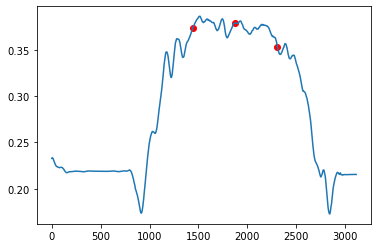

File path :  ./EMG_RMS_Data/P01_Left_Flexion.csv
Plateau Points : 1253 , 2149


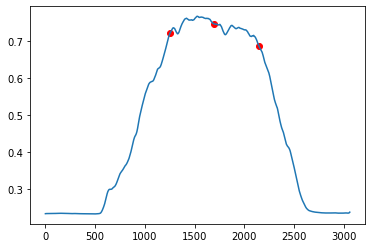

File path :  ./EMG_RMS_Data/P01_Right_Extension.csv
Plateau Points : 1270 , 2100


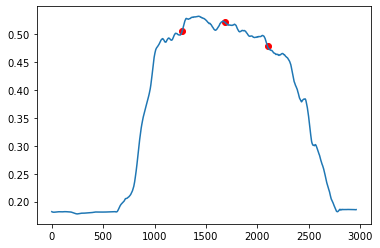

File path :  ./EMG_RMS_Data/P01_Right_Flexion.csv
Plateau Points : 1163 , 2083


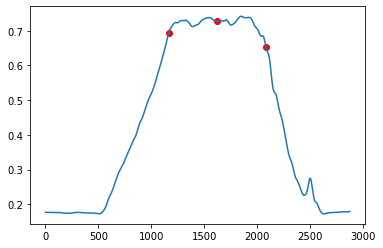



 P02 

File path :  ./EMG_RMS_Data/P02_Left_Extension3.csv
Plateau Points : 1118 , 1987


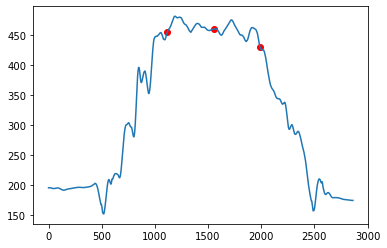

File path :  ./EMG_RMS_Data/P02_Left_Flexion2.csv
Plateau Points : 1164 , 1933


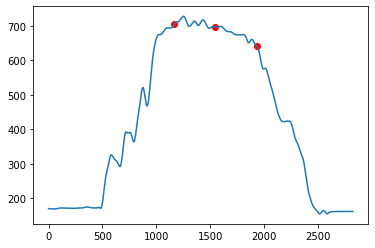

File path :  ./EMG_RMS_Data/P02_Right_Extension3.csv
Plateau Points : 995 , 1467


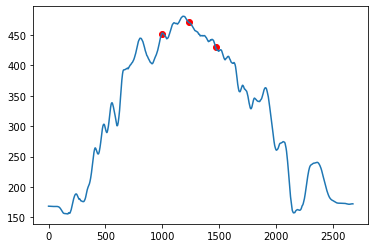

File path :  ./EMG_RMS_Data/P02_Right_Flexion3.csv
Plateau Points : 1020 , 1877


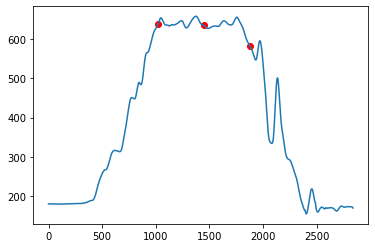



 P03 

File path :  ./EMG_RMS_Data/P03_Left_Extension.csv
Plateau Points : 1660 , 2656


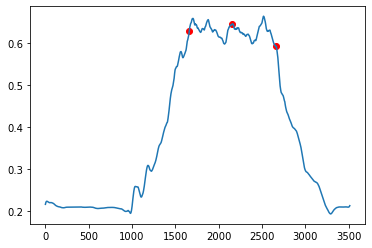

File path :  ./EMG_RMS_Data/P03_Left_Flexion.csv
Plateau Points : 977 , 1957


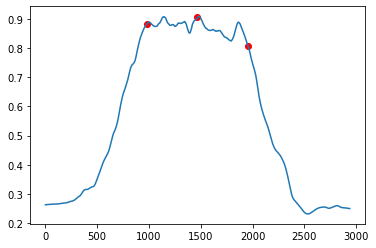

File path :  ./EMG_RMS_Data/P03_Right_Extension2.csv
Plateau Points : 1057 , 1701


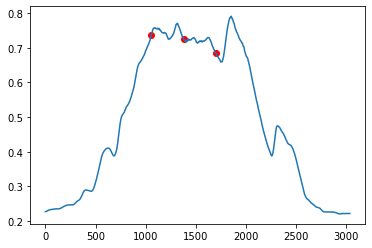

File path :  ./EMG_RMS_Data/P03_Right_Flexion1.csv
Plateau Points : 1071 , 1840


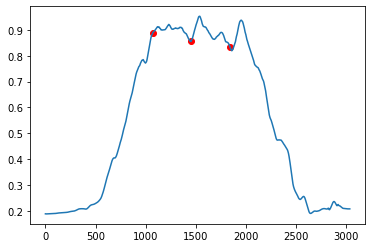



 P04 

File path :  ./EMG_RMS_Data/P04_Left_Extension.csv
Plateau Points : 965 , 1973


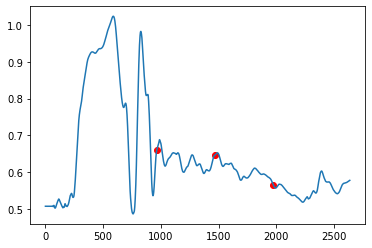

File path :  ./EMG_RMS_Data/P04_Left_Flexion.csv
Plateau Points : 951 , 1411
Plateau Points : 1411 , 1824


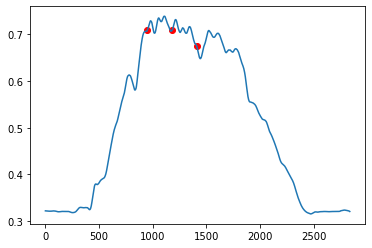

File path :  ./EMG_RMS_Data/P04_Right_Extension.csv
Plateau Points : 1358 , 1713


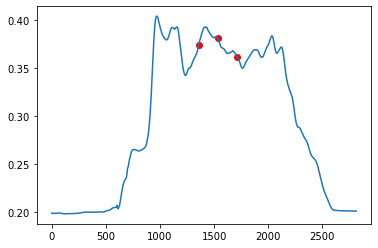

File path :  ./EMG_RMS_Data/P04_Right_Flexion.csv
Plateau Points : 1247 , 1941


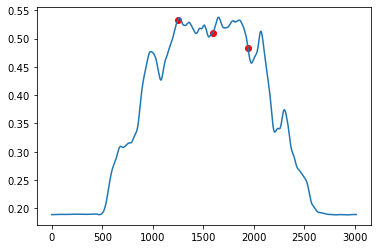



 P05 

File path :  ./EMG_RMS_Data/P05_Left_Extension.csv
Plateau Points : 1094 , 1959


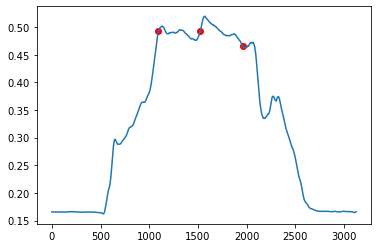

File path :  ./EMG_RMS_Data/P05_Left_Flexion.csv
Plateau Points : 1016 , 1941


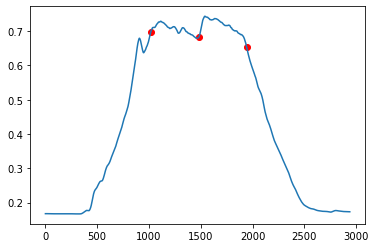

File path :  ./EMG_RMS_Data/P05_Right_Extension.csv
Plateau Points : 1273 , 2011


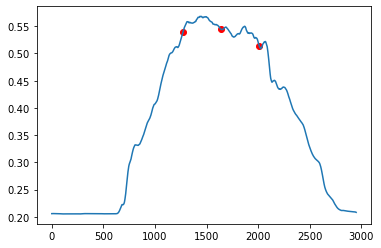

File path :  ./EMG_RMS_Data/P05_Right_Flexion.csv
Plateau Points : 890 , 1870


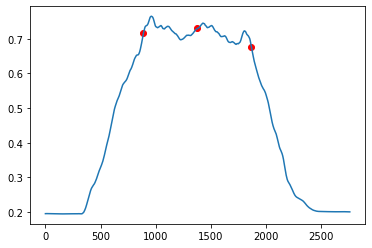



 P06 

File path :  ./EMG_RMS_Data/P06_Left_Extension.csv
Plateau Points : 873 , 1771


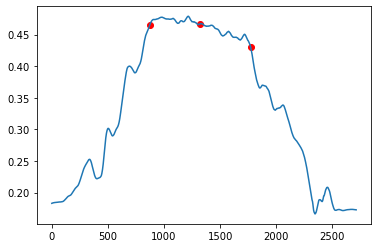

File path :  ./EMG_RMS_Data/P06_Left_Flexion.csv
Plateau Points : 930 , 1337


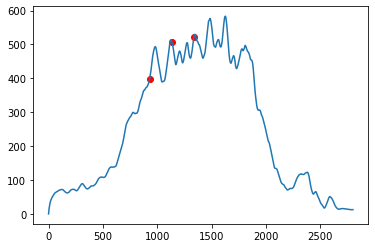

File path :  ./EMG_RMS_Data/P06_Right_Extension.csv
Plateau Points : 931 , 1398


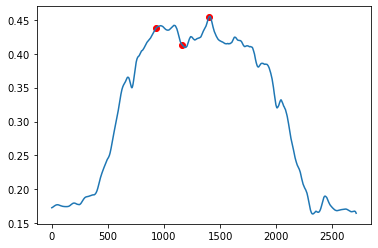

File path :  ./EMG_RMS_Data/P06_Right_Flexion.csv
Plateau Points : 943 , 1855


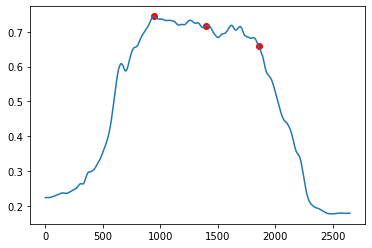



 P09 

File path :  ./EMG_RMS_Data/P09_Left_Extension.csv
Plateau Points : 685 , 1658


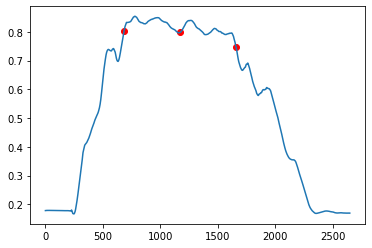

File path :  ./EMG_RMS_Data/P09_Left_Flexion.csv
Plateau Points : 882 , 1774


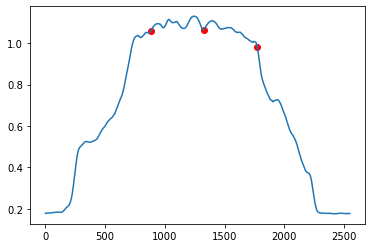

File path :  ./EMG_RMS_Data/P09_Right_Extension.csv
Plateau Points : 829 , 1856


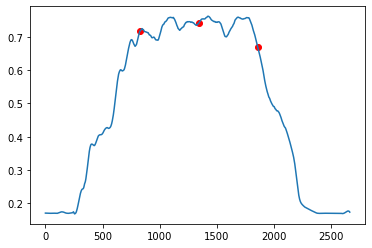

File path :  ./EMG_RMS_Data/P09_Right_Flexion.csv
Plateau Points : 884 , 1877


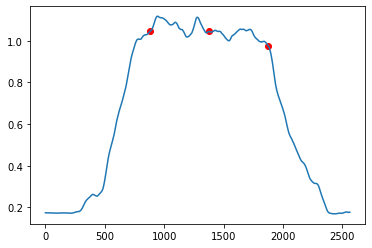



 P10 

File path :  ./EMG_RMS_Data/P10_Left_Extension.csv
Plateau Points : 879 , 1873


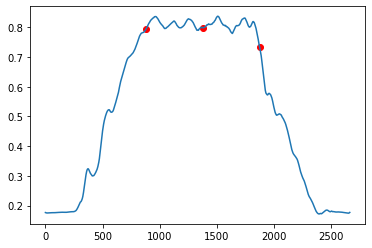

File path :  ./EMG_RMS_Data/P10_Left_Flexion.csv
Plateau Points : 892 , 1781


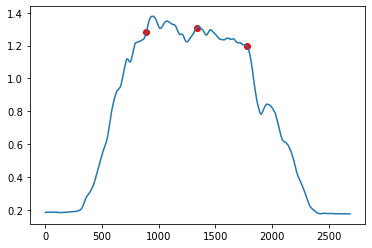

File path :  ./EMG_RMS_Data/P10_Right_Extension.csv
Plateau Points : 1137 , 1845


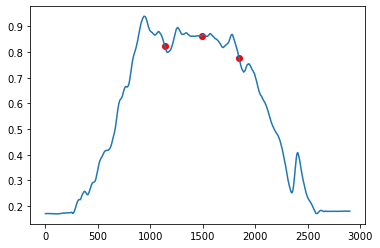

File path :  ./EMG_RMS_Data/P10_Right_Flexion.csv
Plateau Points : 939 , 1872


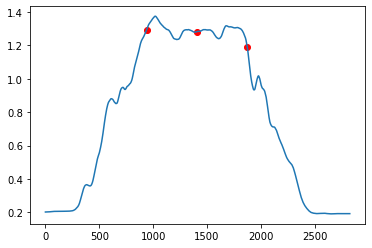



 P11 

File path :  ./EMG_RMS_Data/P11_Left_Extension.csv
Plateau Points : 806 , 1578


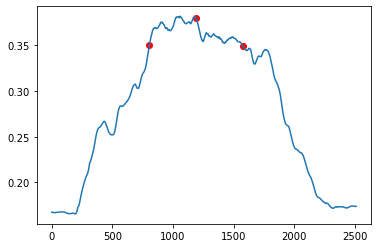

File path :  ./EMG_RMS_Data/P11_Left_Flexion.csv
Plateau Points : 830 , 1842


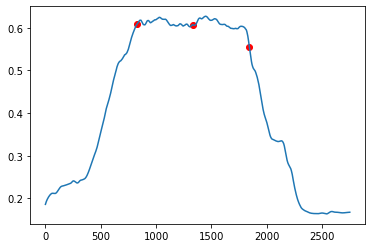

File path :  ./EMG_RMS_Data/P11_Right_Extension.csv
Plateau Points : 801 , 1766


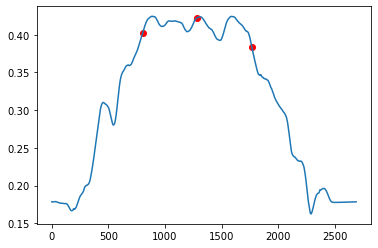

File path :  ./EMG_RMS_Data/P11_Right_Flexion.csv
Plateau Points : 993 , 1824


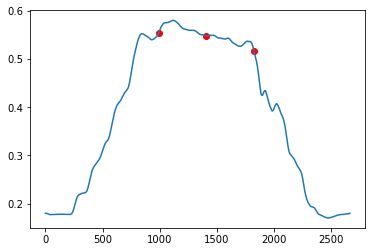



 P12 

File path :  ./EMG_RMS_Data/P12_Left_Extension.csv
Plateau Points : 760 , 1318
Plateau Points : 1318 , 1708


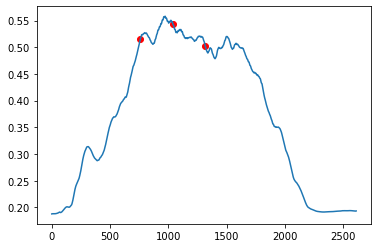

File path :  ./EMG_RMS_Data/P12_Left_Flexion.csv
Plateau Points : 1018 , 1777


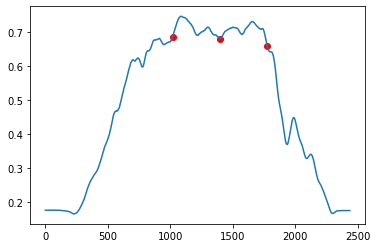

File path :  ./EMG_RMS_Data/P12_Right_Extension.csv
Plateau Points : 944 , 1638


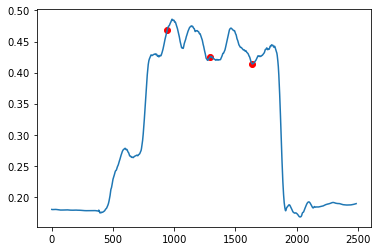

File path :  ./EMG_RMS_Data/P12_Right_Flexion.csv
Plateau Points : 695 , 1385


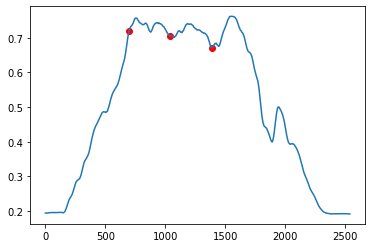



 P13 

File path :  ./EMG_RMS_Data/P13_Left_Extension.csv
Plateau Points : 913 , 1337
Plateau Points : 1337 , 1791


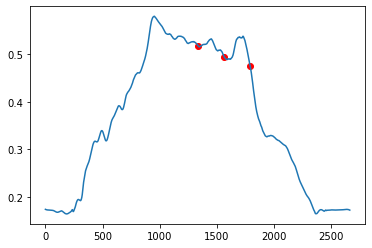

File path :  ./EMG_RMS_Data/P13_Left_Flexion.csv
Plateau Points : 985 , 1839


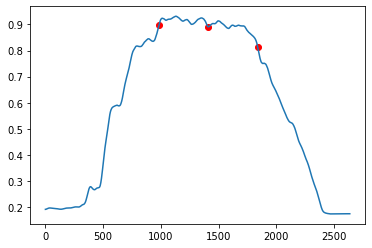

File path :  ./EMG_RMS_Data/P13_Right_Extension.csv
Plateau Points : 890 , 1887


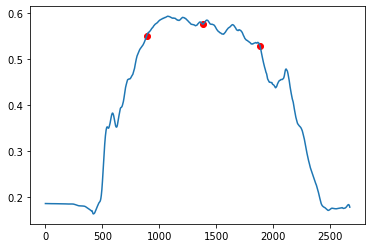

File path :  ./EMG_RMS_Data/P13_Right_Flexion.csv
Plateau Points : 980 , 1845


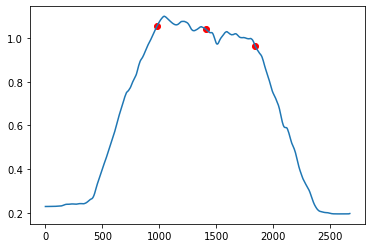



 P14 

File path :  ./EMG_RMS_Data/P14_Left_Extension.csv
Plateau Points : 775 , 1906


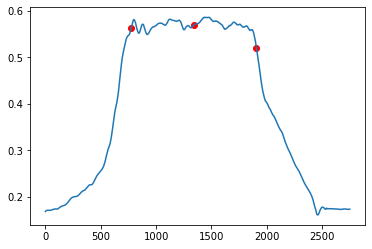

File path :  ./EMG_RMS_Data/P14_Left_Flexion.csv
Plateau Points : 776 , 1610


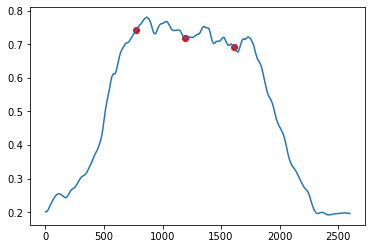

File path :  ./EMG_RMS_Data/P14_Right_Extension.csv
Plateau Points : 833 , 1800


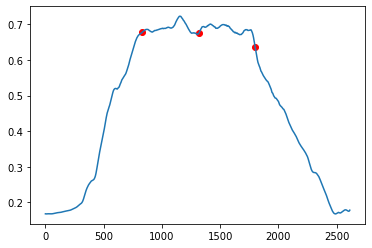

File path :  ./EMG_RMS_Data/P14_Right_Flexion.csv
Plateau Points : 618 , 1274
Plateau Points : 1274 , 1838


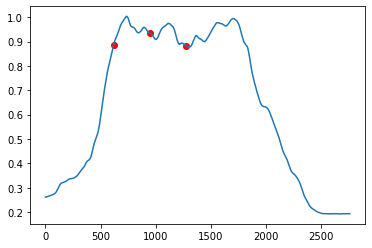



 P15 

File path :  ./EMG_RMS_Data/P15_Left_Extension.csv
Plateau Points : 798 , 1888


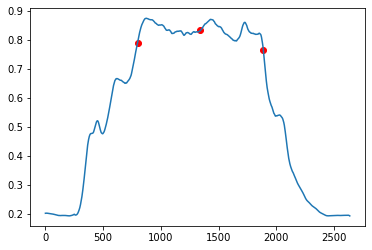

File path :  ./EMG_RMS_Data/P15_Left_Flexion.csv
Plateau Points : 933 , 1901


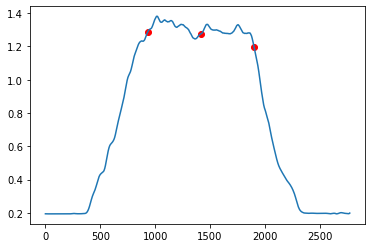

File path :  ./EMG_RMS_Data/P15_Right_Extension.csv
Plateau Points : 791 , 1494


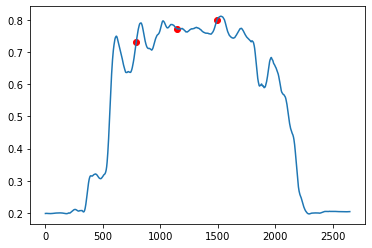

File path :  ./EMG_RMS_Data/P15_Right_Flexion.csv
Plateau Points : 798 , 1754


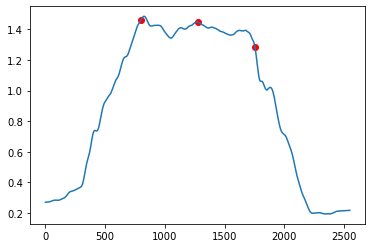



 P16 

File path :  ./EMG_RMS_Data/P16_Left_Extension.csv
Plateau Points : 1265 , 1653


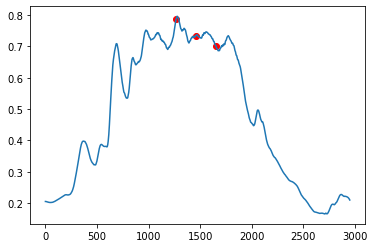

File path :  ./EMG_RMS_Data/P16_Left_Flexion.csv
Plateau Points : 885 , 1764


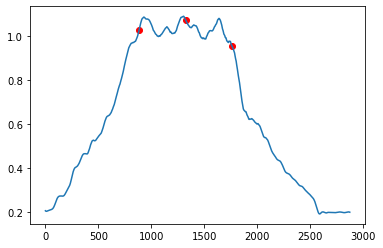

File path :  ./EMG_RMS_Data/P16_Right_Extension.csv
Plateau Points : 1171 , 1889


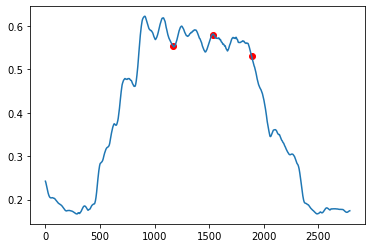

File path :  ./EMG_RMS_Data/P16_Right_Flexion.csv
Plateau Points : 916 , 1756


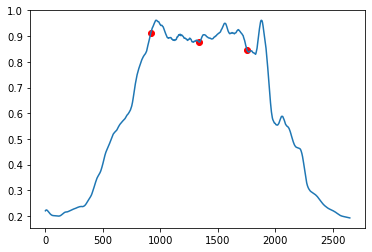



 P17 

File path :  ./EMG_RMS_Data/P17_Left_Extension.csv
Plateau Points : 986 , 1771


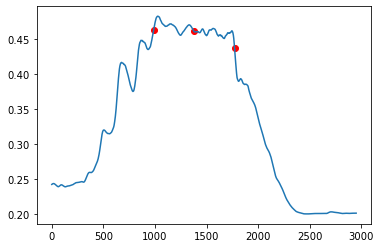

File path :  ./EMG_RMS_Data/P17_Left_Flexion.csv
Plateau Points : 712 , 1553


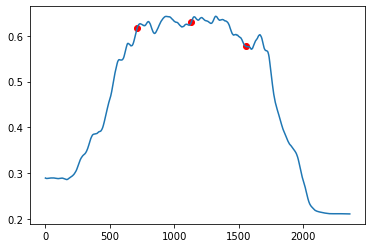

File path :  ./EMG_RMS_Data/P17_Right_Extension.csv
Plateau Points : 896 , 1372


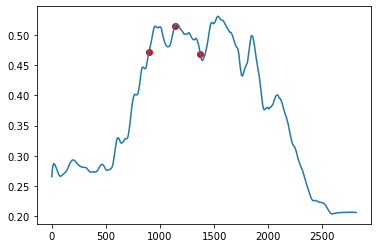

File path :  ./EMG_RMS_Data/P17_Right_Flexion.csv
Plateau Points : 816 , 1587


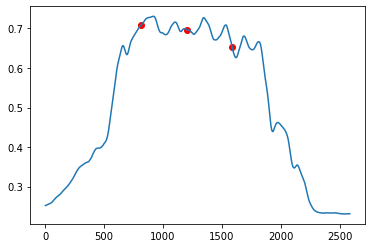



 P18 

File path :  ./EMG_RMS_Data/P18_Left_Extension.csv
Plateau Points : 858 , 1443


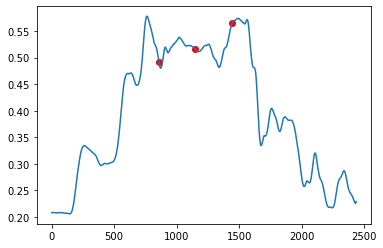

File path :  ./EMG_RMS_Data/P18_Left_Flexion.csv
Plateau Points : 808 , 1760


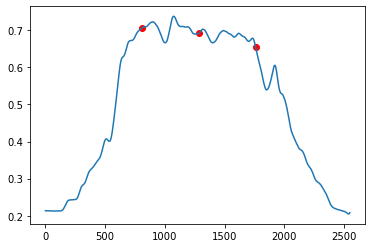

File path :  ./EMG_RMS_Data/P18_Right_Extension.csv
Plateau Points : 923 , 1685


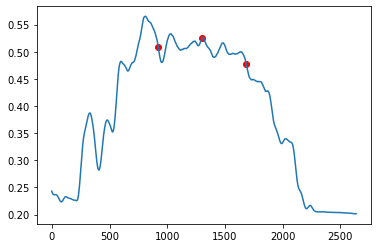

File path :  ./EMG_RMS_Data/P18_Right_Flexion.csv
Plateau Points : 765 , 1760


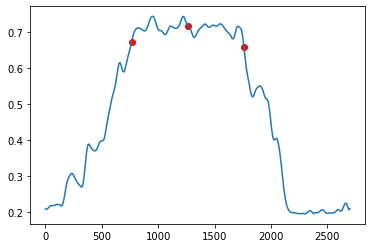



 P19 

File path :  ./EMG_RMS_Data/P19_Left_Extension.csv
Plateau Points : 899 , 1808


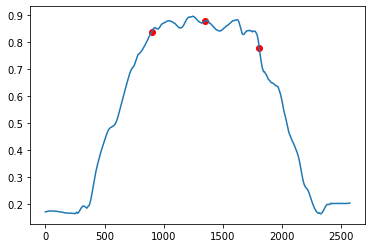

File path :  ./EMG_RMS_Data/P19_Left_Flexion.csv
Plateau Points : 939 , 1868


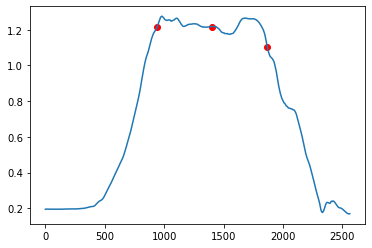

File path :  ./EMG_RMS_Data/P19_Right_Extension.csv
Plateau Points : 970 , 1646


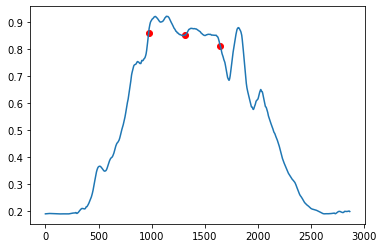

File path :  ./EMG_RMS_Data/P19_Right_Flexion.csv
Plateau Points : 844 , 1756


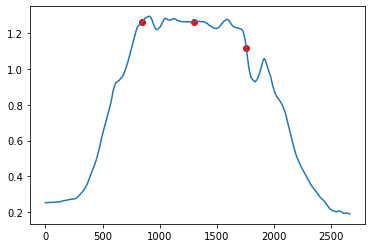



 P20 

File path :  ./EMG_RMS_Data/P20_Left_Extension.csv
Plateau Points : 972 , 1935


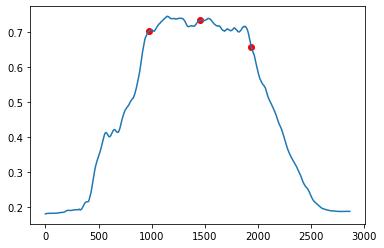

File path :  ./EMG_RMS_Data/P20_Left_Flexion.csv
Plateau Points : 1022 , 1864


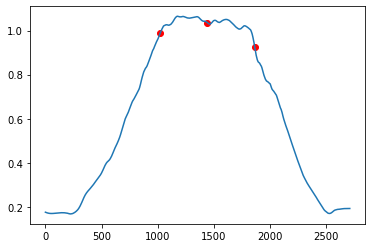

File path :  ./EMG_RMS_Data/P20_Right_Extension.csv
Plateau Points : 1136 , 1709


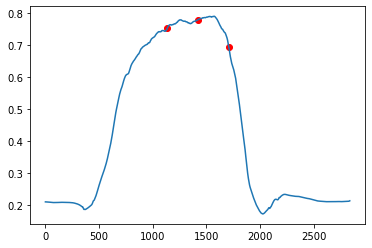

File path :  ./EMG_RMS_Data/P20_Right_Flexion.csv
Plateau Points : 965 , 1714


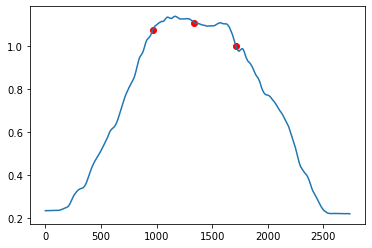



 P24 

File path :  ./EMG_RMS_Data/P24_Left_Extension3.csv
Plateau Points : 1179 , 1813


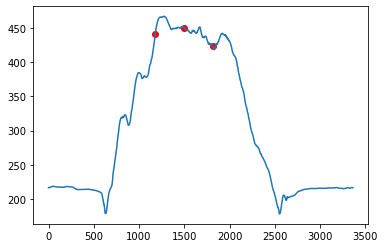

File path :  ./EMG_RMS_Data/P24_Left_Flexion2.csv
Plateau Points : 1312 , 2161


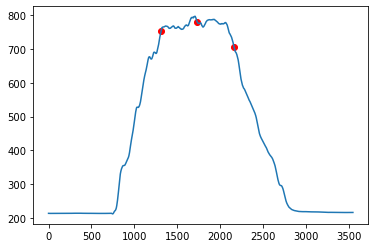

File path :  ./EMG_RMS_Data/P24_Right_Extension2.csv
Plateau Points : 1291 , 1920


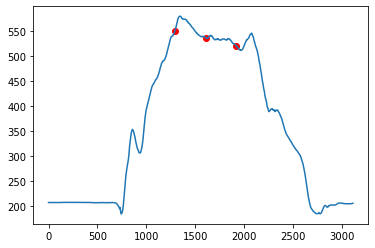

File path :  ./EMG_RMS_Data/P24_Right_Flexion3.csv
Plateau Points : 1389 , 2111


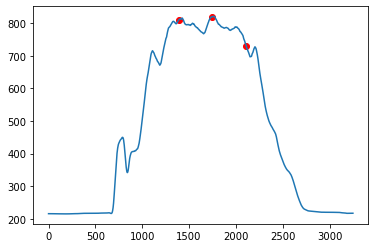



 P25 

File path :  ./EMG_RMS_Data/P25_Left_Extension3.csv
Plateau Points : 824 , 1826


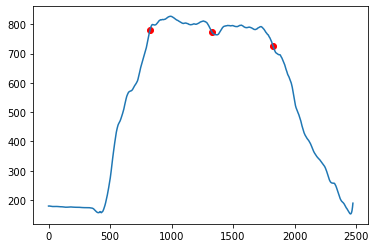

File path :  ./EMG_RMS_Data/P25_Left_Flexion2.csv
Plateau Points : 1214 , 2246


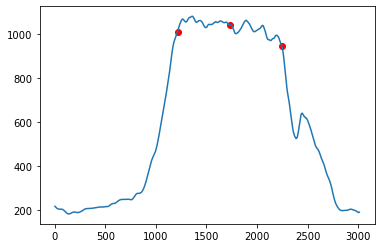

File path :  ./EMG_RMS_Data/P25_Right_Extension1.csv
Plateau Points : 798 , 1783


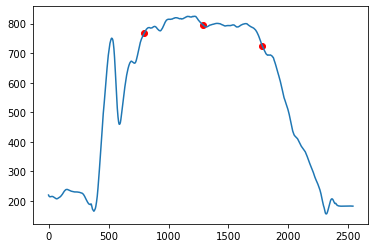

File path :  ./EMG_RMS_Data/P25_Right_Flexion2.csv
Plateau Points : 847 , 1706


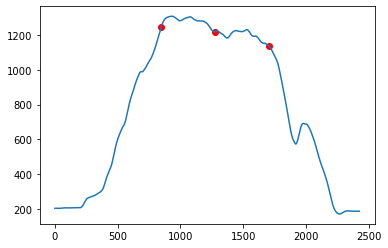



 P26 

File path :  ./EMG_RMS_Data/P26_Left_Extension3.csv
Plateau Points : 1045 , 1966


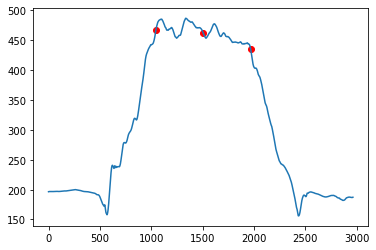

File path :  ./EMG_RMS_Data/P26_Left_Flexion3.csv
Plateau Points : 1175 , 2014


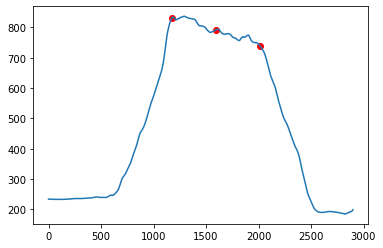

File path :  ./EMG_RMS_Data/P26_Right_Extension3.csv
Plateau Points : 984 , 1888


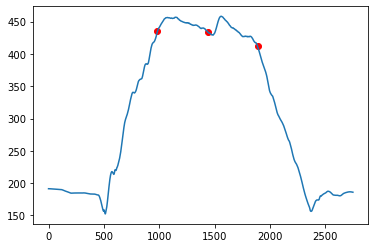

File path :  ./EMG_RMS_Data/P26_Right_Flexion3.csv
Plateau Points : 1323 , 2172


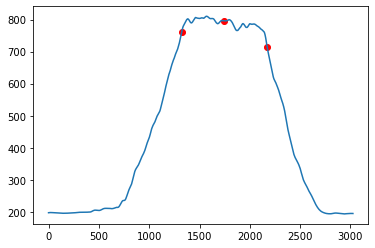



 P30 

File path :  ./EMG_RMS_Data/P30_Left_Extension2.csv
Plateau Points : 1020 , 1661


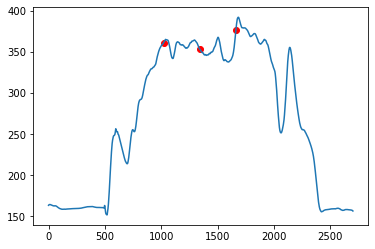

File path :  ./EMG_RMS_Data/P30_Left_Flexion3.csv
Plateau Points : 1240 , 2223


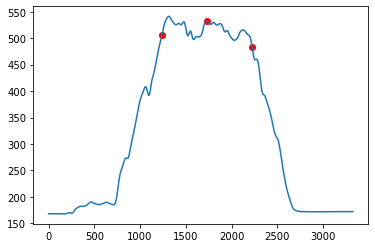

File path :  ./EMG_RMS_Data/P30_Right_Extension2.csv
Plateau Points : 1449 , 2446


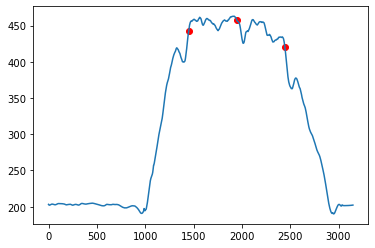

File path :  ./EMG_RMS_Data/P30_Right_Flexion1.csv
Plateau Points : 1362 , 2239


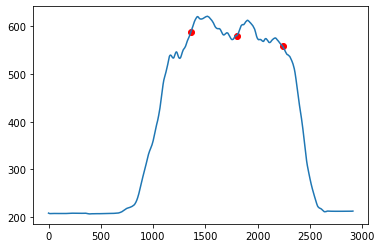



 P31 

File path :  ./EMG_RMS_Data/P31_Left_Extension3.csv
Plateau Points : 1368 , 1901


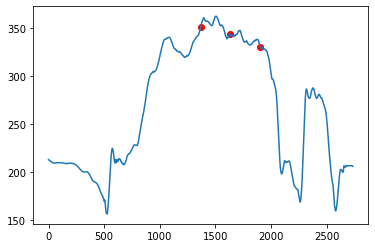

File path :  ./EMG_RMS_Data/P31_Left_Flexion2.csv
Plateau Points : 1105 , 1708


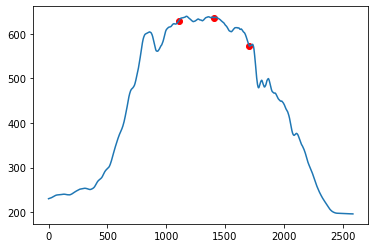

File path :  ./EMG_RMS_Data/P31_Right_Extension2.csv
Plateau Points : 1065 , 1483


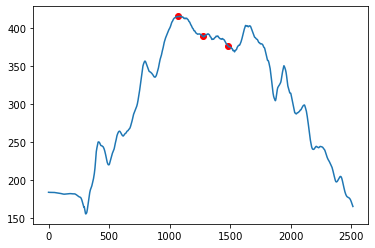

File path :  ./EMG_RMS_Data/P31_Right_Flexion2.csv
Plateau Points : 1092 , 2009


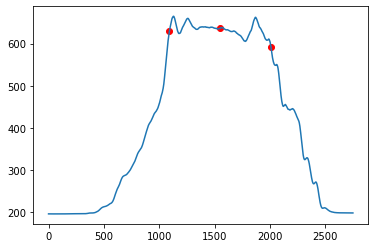



 P32 

File path :  ./EMG_RMS_Data/P32_Left_Extension3.csv
Plateau Points : 1364 , 1800


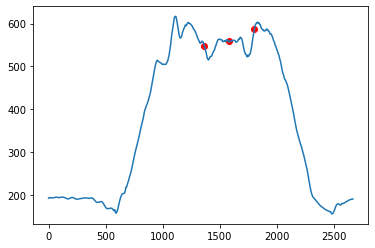

File path :  ./EMG_RMS_Data/P32_Left_Flexion1.csv
Plateau Points : 1130 , 1973


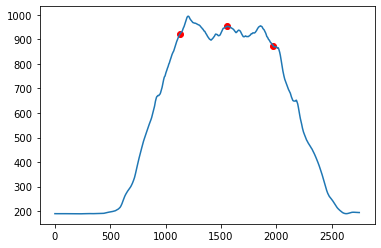

File path :  ./EMG_RMS_Data/P32_Right_Extension3.csv
Plateau Points : 1024 , 1972


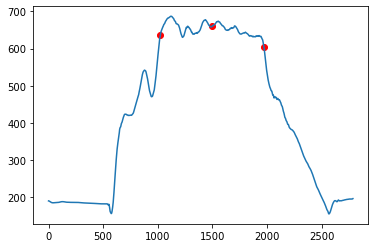

File path :  ./EMG_RMS_Data/P32_Right_Flexion1.csv
Plateau Points : 962 , 1835


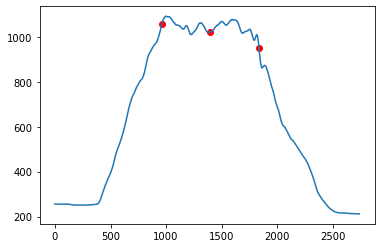



 P33 

File path :  ./EMG_RMS_Data/P33_Left_Extension3.csv
Plateau Points : 1317 , 1993


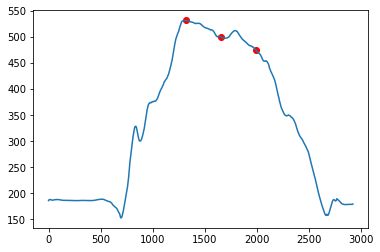

File path :  ./EMG_RMS_Data/P33_Left_Flexion2.csv
Plateau Points : 1060 , 2060


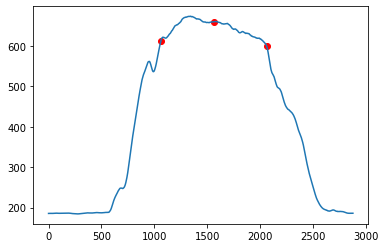

File path :  ./EMG_RMS_Data/P33_Right_Extension3.csv
Plateau Points : 1169 , 2039


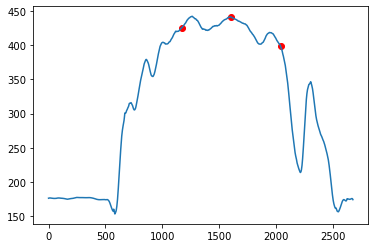

File path :  ./EMG_RMS_Data/P33_Right_Flexion1.csv
Plateau Points : 1074 , 1594
Plateau Points : 1594 , 2022


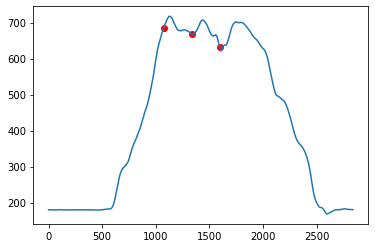



 P34 

File path :  ./EMG_RMS_Data/P34_Left_Extension2.csv
Plateau Points : 946 , 1990


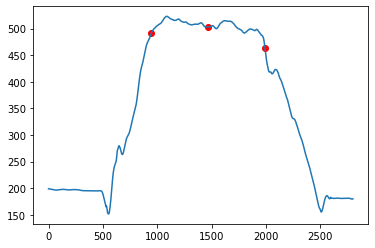

File path :  ./EMG_RMS_Data/P34_Left_Flexion3.csv
Plateau Points : 910 , 1784


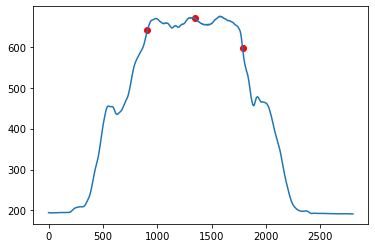

File path :  ./EMG_RMS_Data/P34_Right_Extension3.csv
Plateau Points : 1090 , 1974


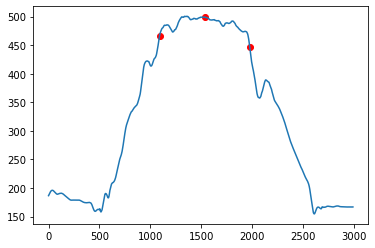

File path :  ./EMG_RMS_Data/P34_Right_Flexion3.csv
Plateau Points : 1038 , 1975


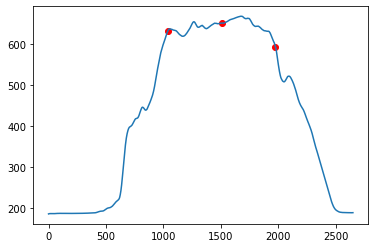



 P35 

File path :  ./EMG_RMS_Data/P35_Left_Extension3.csv
Plateau Points : 1081 , 1567
Plateau Points : 1567 , 1966


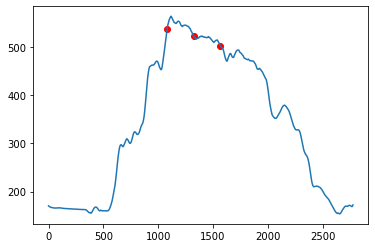

File path :  ./EMG_RMS_Data/P35_Left_Flexion2.csv
Plateau Points : 1175 , 2084


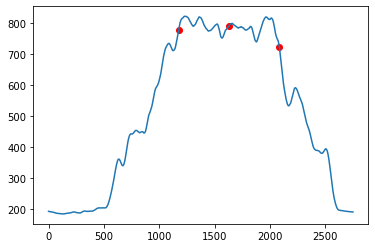

File path :  ./EMG_RMS_Data/P35_Right_Extension2.csv
Plateau Points : 1583 , 1958


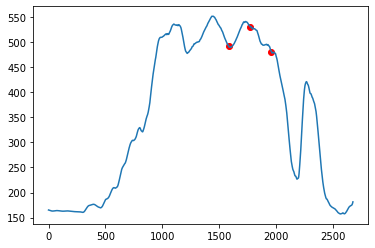

File path :  ./EMG_RMS_Data/P35_Right_Flexion3.csv
Plateau Points : 902 , 1825


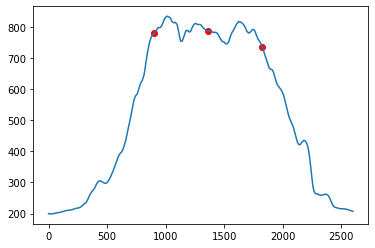



 P36 

File path :  ./EMG_RMS_Data/P36_Left_Extension3.csv
Plateau Points : 1097 , 1629


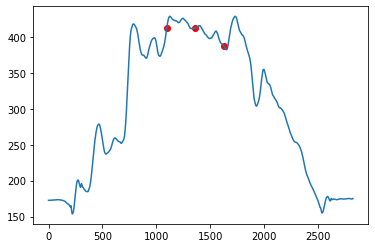

File path :  ./EMG_RMS_Data/P36_Left_Flexion3.csv
Plateau Points : 1147 , 1833


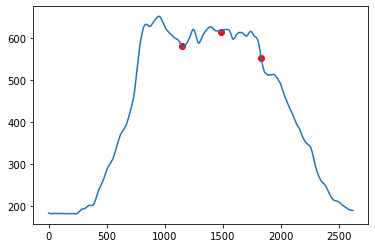

File path :  ./EMG_RMS_Data/P36_Right_Extension3.csv
Plateau Points : 1266 , 1692


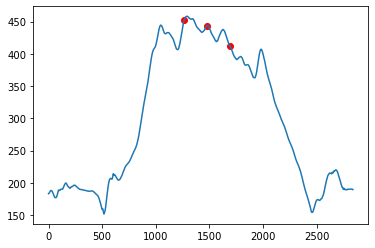

File path :  ./EMG_RMS_Data/P36_Right_Flexion3.csv
Plateau Points : 1252 , 1909


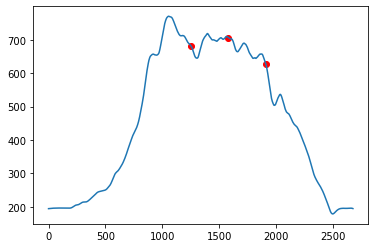



 P37 

File path :  ./EMG_RMS_Data/P37_Left_Extension3.csv
Plateau Points : 1178 , 1614


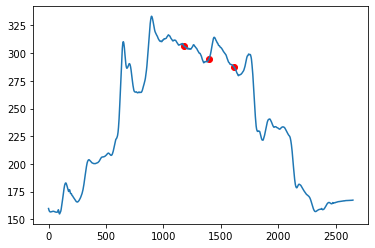

File path :  ./EMG_RMS_Data/P37_Left_Flexion1.csv
Plateau Points : 905 , 1909


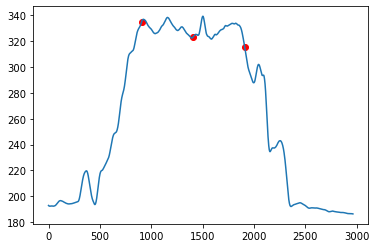

File path :  ./EMG_RMS_Data/P37_Right_Extension3.csv
Plateau Points : 719 , 1236
Plateau Points : 1236 , 1595


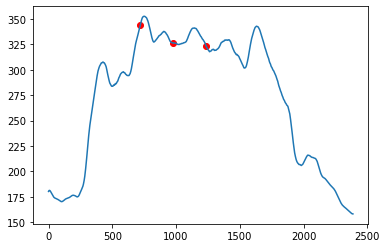

File path :  ./EMG_RMS_Data/P37_Right_Flexion1.csv
Plateau Points : 2346 , 3322


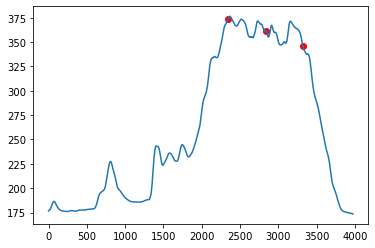



 P38 

File path :  ./EMG_RMS_Data/P38_Left_Extension3.csv
Plateau Points : 1091 , 1758


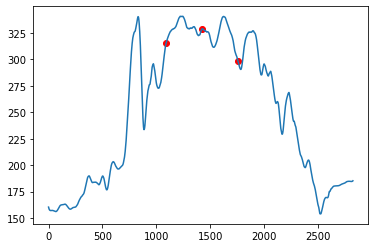

File path :  ./EMG_RMS_Data/P38_Left_Flexion2.csv
Plateau Points : 1033 , 1760


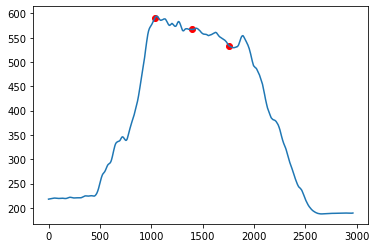

File path :  ./EMG_RMS_Data/P38_Right_Extension2.csv
Plateau Points : 1413 , 1845


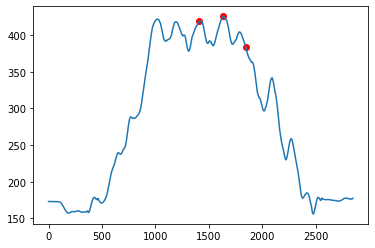

File path :  ./EMG_RMS_Data/P38_Right_Flexion2.csv
Plateau Points : 1136 , 1750


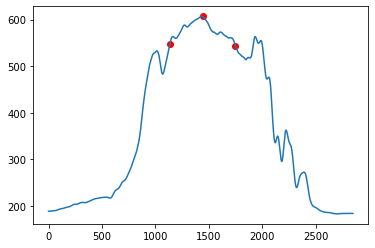

In [3]:
file_path = 'MVC_Data.csv'

# Labels to be written
labels = ['Participants', 'Arm', 'Exercise type', 'MVC Index']
for i in range(number_of_grids):
    labels.append('G' + str(i+1) + ' RMS Value')

# Check if the file exists
if os.path.exists(file_path):
    with open(file_path, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(labels)
else:
    with open(file_path, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(labels)

folder_path = './EMG_RMS_Data'
result_list = get_unique_first_substrings(folder_path)
result_list = check_files_availability(result_list,folder_path)
result_list.sort()
print("These are the list of participants whose files can be processed for MVC : ", result_list)

for participant in result_list:
    
    print("\n\n",participant,"\n")
    get_MVCs(participant, folder_path,number_of_grids)